# Titanic: Machine Learning from Disaster

## Importing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Feature Exploration, Engineering and Cleaning

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

passengerID = test.PassengerId

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering

In [3]:
full_data = [train, test]

titles_stuff = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for ds in full_data:
    
    ds['Name_len'] = ds['Name'].apply(len)
    ds['FamilySize'] = ds['SibSp'] + ds['Parch'] + 1
    
    ds['IsAlone'] = ds['FamilySize'].apply(lambda x: 1 if x==1 else 0)
    ds['Has_Cabin'] = ds['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
    
    ds['Embarked'].fillna('S', inplace=True)
    ds['Fare'].fillna(ds['Fare'].median(), inplace=True)
    
    #age feature proccessing
    age_avg = ds['Age'].mean()
    age_std = ds['Age'].std()
    age_null_count = ds['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    ds['Age'][ds['Age'].isnull()] = age_null_random_list
    ds['Age'] = ds['Age'].astype(int)
    
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

for ds in full_data:

    ds['Title'] = ds['Name'].apply(get_title)
    
    for s in [(titles_stuff, 'Rare'), ('Mlle', 'Miss'), ('Ms', 'Miss'), ('Mme', 'Mrs')]:
        ds['Title'] = ds['Title'].replace(*s)
    
    # Mapping Sex
    ds['Sex'] = ds['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    ds['Title'] = ds['Title'].map(title_mapping)
    ds['Title'] = ds['Title'].fillna(0)
    
    # Mapping Embarked
    ds['Embarked'] = ds['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    ds.loc[ ds['Fare'] <= 7.91, 'Fare']         = 0
    ds.loc[(ds['Fare'] > 7.91) & (ds['Fare'] <= 14.454), 'Fare'] = 1
    ds.loc[(ds['Fare'] > 14.454) & (ds['Fare'] <= 31), 'Fare']   = 2
    ds.loc[ ds['Fare'] > 31, 'Fare']         = 3
    ds['Fare'] = ds['Fare'].astype(int)
    
    # Mapping Age
    ds.loc[ ds['Age'] <= 16, 'Age'] = 0
    ds.loc[(ds['Age'] > 16) & (ds['Age'] <= 32), 'Age'] = 1
    ds.loc[(ds['Age'] > 32) & (ds['Age'] <= 48), 'Age'] = 2
    ds.loc[(ds['Age'] > 48) & (ds['Age'] <= 64), 'Age'] = 3
    ds.loc[ ds['Age'] > 64, 'Age'] = 4 ;

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_len,FamilySize,IsAlone,Has_Cabin,Title
0,0,3,1,1,0,0,0,23,2,0,0,1
1,1,1,0,2,0,3,1,51,2,0,1,3
2,1,3,0,1,0,1,0,22,1,1,0,2
3,1,1,0,2,0,3,0,44,2,0,1,3
4,0,3,1,2,0,1,0,24,1,1,0,1


### Pearson Correlation Heatmap

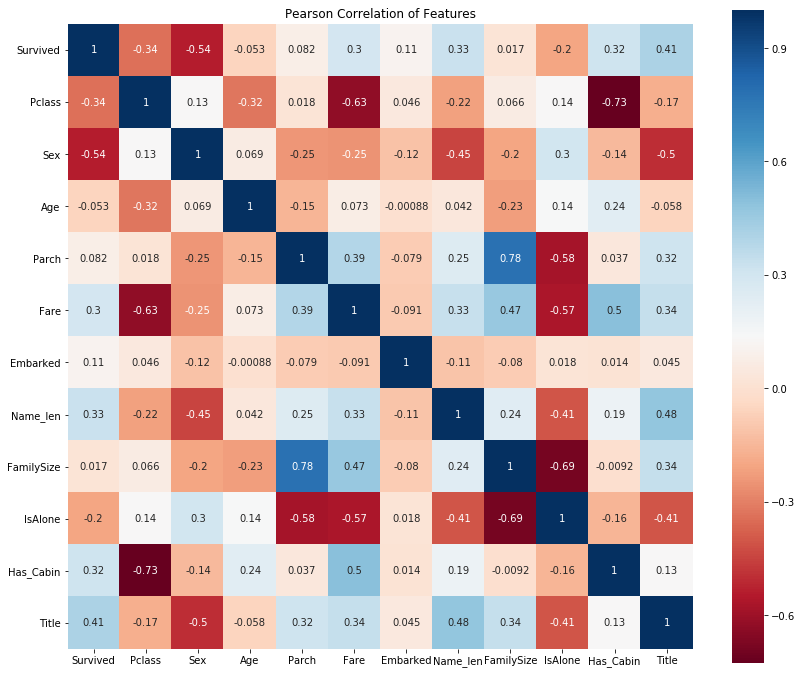

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features')

sns.heatmap(train.astype(float).corr(), cmap=colormap, annot=True, square=True)

### Pairplots

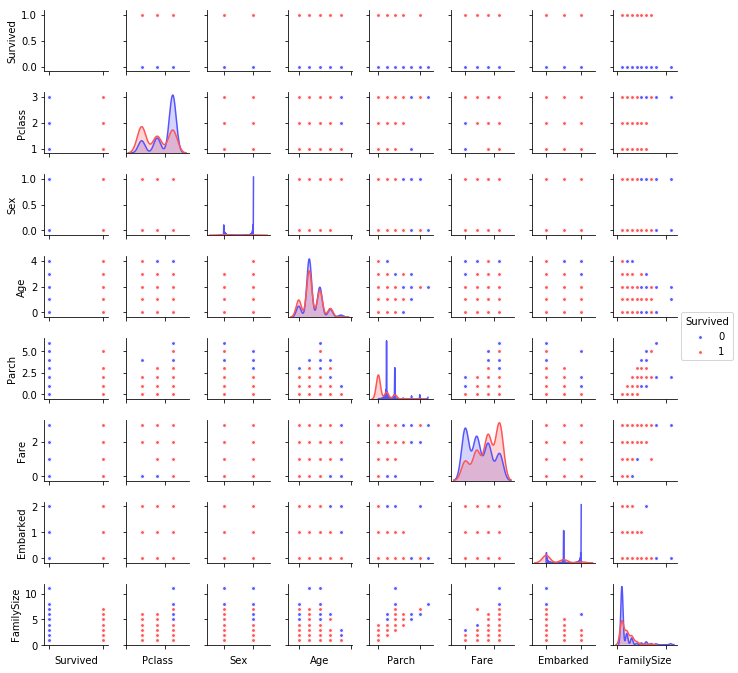

In [7]:
g = sns.pairplot(train.drop(['Name_len', 'IsAlone', 'Has_Cabin', 'Title'], axis=1),
                 hue='Survived',
                 palette='seismic',
                 size=1.2,
                 diag_kind='kde',
                 diag_kws=dict(shade=True),
                 plot_kws=dict(s=15))
g.set(xticklabels=[])

## Ensembling & Stacking models

### Helpers via Python Classes

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]

SEED = 0
NFOLDS = 5

kf = KFold(n_splits=NFOLDS, random_state=SEED)

class SklearnHelper(object):
    
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, Xtrain, ytrain):
        self.clf.fit(Xtrain, ytrain)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def fit(self, X, y):
        return self.clf.fit(X, y)
    
    def feature_importances(self, X, y):
        return self.clf.fit(X, y).feature_importances_

### Out-of-Fold Predictions

In [10]:
def get_oof(clf, Xtrain, ytrain, Xtest):
    
    ntrain = Xtrain.shape[0]
    ntest = Xtest.shape[0]
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(Xtrain)):
        x_tr = Xtrain[train_index]
        y_tr = ytrain[train_index]
        x_te = Xtrain[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(Xtest)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

### Parameters

In [11]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C': 0.025
    }

In [12]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets

In [13]:
ytrain = train['Survived'].ravel()
Xtrain = train.drop('Survived', axis=1).values
Xtest = test.values

### Output of the First level Predictions

In [14]:
et_oof_train, et_oof_test = get_oof(et, Xtrain, ytrain, Xtest) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, Xtrain, ytrain, Xtest) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, Xtrain, ytrain, Xtest) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, Xtrain, ytrain, Xtest) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, Xtrain, ytrain, Xtest) # Support Vector Classifier

### Feature importances generated from the different classifiers

In [15]:
rf_feature = rf.feature_importances(Xtrain, ytrain)
et_feature = et.feature_importances(Xtrain, ytrain)
ada_feature = ada.feature_importances(Xtrain, ytrain)
gb_feature = gb.feature_importances(Xtrain, ytrain)

In [16]:
cols = train.columns.values[1:]
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'Random Forest feature importances': rf_feature,
                                  'Extra Trees  feature importances': et_feature,
                                  'AdaBoost feature importances': ada_feature,
                                  'Gradient Boost feature importances': gb_feature
                                 }, index=cols)

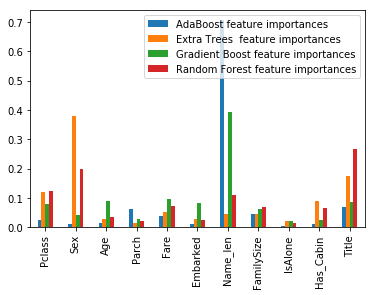

In [22]:
feature_dataframe.plot(kind='bar')
plt.show()

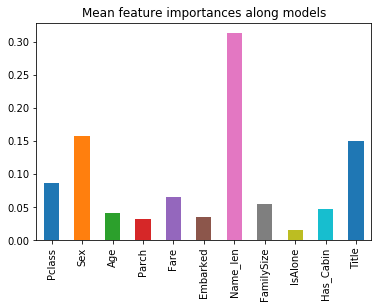

In [21]:
feature_dataframe.mean(axis=1).plot(kind='bar')
plt.title('Mean feature importances along models')
plt.show()

In [26]:
base_prediction_train = pd.DataFrame({'Random Forest': rf_oof_train.ravel(),
                                      'Extra Trees': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'Gradient Boost': gb_oof_train.ravel() 
                                     })

base_prediction_train.head()

,AdaBoost,Extra Trees,Gradient Boost,Random Forest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


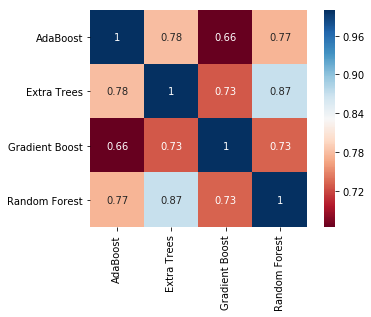

In [27]:
sns.heatmap(base_prediction_train.astype(float).corr(), cmap=colormap, annot=True, square=True)